In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
from datetime import timedelta
import datetime
import math


In [115]:
cd /Users/williamzhou/Downloads/RussianHousing-master

/Users/williamzhou/Downloads/RussianHousing-master


In [156]:
train=pd.read_csv('./data/processed/Clean0517/train_clean_shu_0517.csv')
test = pd.read_csv('./data/processed/Clean0517/test_clean_shu_0517.csv')
macro = pd.read_csv('./data/raw/macro.csv')
# latlon = pd.read_csv('/Users/williamzhou/Documents/github/RussianHousing/data/external/sub_area_lon_lat.csv')
final_feature = list(pd.read_csv('./cv_output/final_feature.csv').iloc[:,0])


train['timestamp'] = pd.to_datetime(train['timestamp'])
macro['timestamp'] = pd.to_datetime(macro['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

print ('train shape',train.shape)
print ('test shape',test.shape)
print('final features',len(final_feature))

('train shape', (30471, 299))
('test shape', (7662, 296))
('final features', 40)


In [157]:
train.loc[train['full_sq'].isnull(),'full_sq']=train['full_sq'].median()
test.loc[test['full_sq'].isnull(),'full_sq']=test['full_sq'].median()
train['price_full_sq']=train['price_doc']/train['full_sq']
train['price_full_sq']=train['price_full_sq'].astype('int64')

print ('train shape',train.shape)
print ('test shape',test.shape)

('train shape', (30471, 300))
('test shape', (7662, 296))


In [158]:
y_train=train['price_full_sq']
x_train= train.drop(['id','price_doc','price_full_sq'],axis=1)
x_test = test.drop(['id'],axis=1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(30471, 297)
(30471,)
(7662, 295)


In [159]:
num_train = len(train)
df_all = pd.concat([x_train,x_test])

In [160]:
df_all[['ID_big_road1','ID_big_road2',
        'ID_bus_terminal','ID_metro',
       'ID_railroad_station_avto',
       'ID_railroad_terminal']]=df_all[['ID_big_road1','ID_big_road2',
                                        'ID_bus_terminal','ID_metro',
                                       'ID_railroad_station_avto',
                                       'ID_railroad_terminal']].astype(object)

df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

for c in df_all.columns:
    if df_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_all[c].values)) 
        df_all[c] = lbl.transform(list(df_all[c].values))

# df_all=df_all.drop(['timestamp'],axis =1 )

x_train = df_all.iloc[:num_train,:]
x_test = df_all.iloc[num_train:,:]



print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('y_train shape',y_train.shape)

('x_train shape', (30471, 299))
('x_test shape', (7662, 299))
('y_train shape', (30471,))


In [161]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

In [165]:
def merge_macro_feature(col_name,n_days,macro,df):
    macro_timeshift=macro.copy()
    macro_timeshift['timestamp']=macro.timestamp+timedelta(days=n_days)
    df = pd.merge(df,macro_timeshift[['timestamp',col_name]],on='timestamp',how='left')
    df = df.drop(['timestamp'],axis = 1 )
    print(df.shape)
    return(df)

In [166]:
macro_col = ['usdrub','eurrub',"balance_trade",'balance_trade_growth',
                "micex_rgbi_tr","micex_cbi_tr",'micex','deposits_rate',
                'mortgage_value','mortgage_rate','income_per_cap',
                'rent_price_4+room_bus','apartment_build','brent',
                'oil_urals','cpi','ppi','gdp_quart','deposits_value',
                'mortgage_growth']

In [182]:
%%time
# Greedy search best TIME ELAPSE FOR MACRO FEATURE

for col_name in macro_col:
    test_rmse_bag = []
    for n_days in range(-14,120,7):
        x_train_subset = x_train.loc[:,final_feature+['timestamp']]
        x_test_subset = x_test.loc[:,final_feature+['timestamp']]
        x_train_subset = merge_macro_feature(col_name,n_days,macro,x_train_subset)
        x_test_subset = merge_macro_feature(col_name,n_days,macro,x_test_subset)
        print('Add {} to dataframe with {} days laps'.format(col_name,n_days))
        dtrain_subset = xgb.DMatrix(x_train_subset, y_train)
        dtest_subset =  xgb.DMatrix(x_test_subset)
        print('Start training........')
        cv_output = xgb.cv(xgb_params, dtrain_subset, 
                   num_boost_round=1000, 
                   early_stopping_rounds=20,
                   verbose_eval=50, show_stdv=False)
        print ('CV finished')
        test_rmse = cv_output.loc[len(cv_output)-1,'test-rmse-mean']
        test_rmse_bag.append(test_rmse)
        print ('.....................')
        
    min_test_rmse=np.min(test_rmse_bag)
    if min_test_rmse<= 40402.5:
        print('Congrat! Lowest test rmse of {} is {},which smaller than current best rmse 40402.5'.format(col_name,min_test_rmse))
    else:
        print('Sorry! Lowest test rmse of {} is {},which is not an improvement'.format(col_name,min_test_rmse))
    result = pd.DataFrame({'n_days':range(-14,120,7),'test_rmse':test_rmse_bag})
    result.to_csv('./find_macro_time_laps/{}.csv'.format(col_name))
    print('{} test rmse result saved'.format(col_name))
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')


(30471, 41)
(7662, 41)
Add usdrub to dataframe with -14 days laps
Start training........
[0]	train-rmse:137644	test-rmse:137656
[50]	train-rmse:42290.8	test-rmse:44157.6
[100]	train-rmse:38671.3	test-rmse:41705.8
[150]	train-rmse:37111.9	test-rmse:41156.7
[200]	train-rmse:35896.4	test-rmse:40889.8
[250]	train-rmse:34875.9	test-rmse:40705.9
[300]	train-rmse:33985.6	test-rmse:40589.4
[350]	train-rmse:33140.6	test-rmse:40525.1
[400]	train-rmse:32364.5	test-rmse:40501.4
[450]	train-rmse:31582.9	test-rmse:40477.2
CV finished
.....................
(30471, 41)
(7662, 41)
Add usdrub to dataframe with -7 days laps
Start training........
[0]	train-rmse:137644	test-rmse:137656
[50]	train-rmse:42270.3	test-rmse:44123
[100]	train-rmse:38645.9	test-rmse:41654.5
[150]	train-rmse:37129.4	test-rmse:41106.6
[200]	train-rmse:35895.1	test-rmse:40813.9
[250]	train-rmse:34878.5	test-rmse:40654.3
[300]	train-rmse:33961.7	test-rmse:40543.3
[350]	train-rmse:33095.3	test-rmse:40497.6
[400]	train-rmse:32297.7	te

(20, 3)


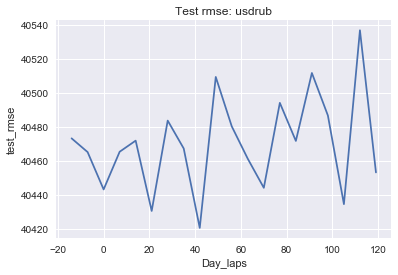

Sorry! Lowest test rmse of usdrub is 40420.488281,which is not an improvement
(20, 3)


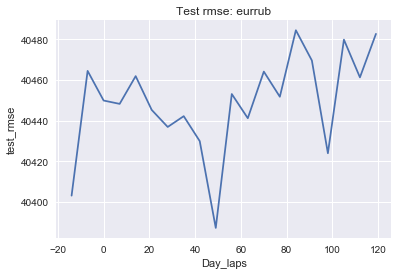

Congrat! Lowest test rmse of eurrub is 40387.313802,which smaller than current best rmse 40402.5
Best time lapse is 49
(20, 3)


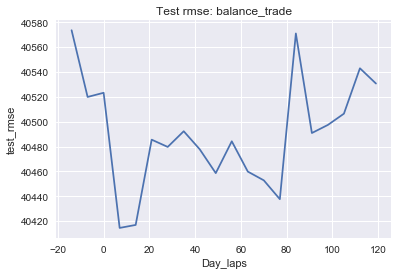

Sorry! Lowest test rmse of balance_trade is 40414.5013023,which is not an improvement
(20, 3)


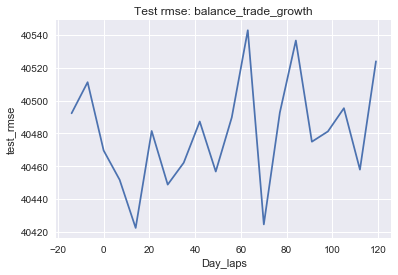

Sorry! Lowest test rmse of balance_trade_growth is 40422.4127603,which is not an improvement
(20, 3)


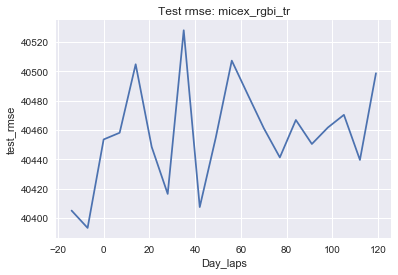

Congrat! Lowest test rmse of micex_rgbi_tr is 40393.096354,which smaller than current best rmse 40402.5
Best time lapse is -7
(20, 3)


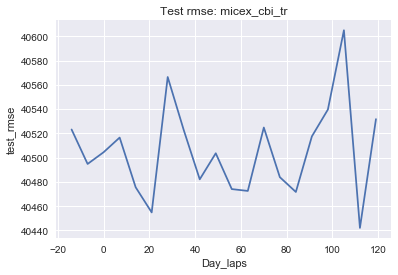

Sorry! Lowest test rmse of micex_cbi_tr is 40442.0351563,which is not an improvement
(20, 3)


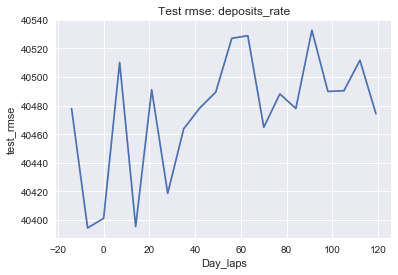

Congrat! Lowest test rmse of deposits_rate is 40394.4322917,which smaller than current best rmse 40402.5
Best time lapse is -7
(20, 3)


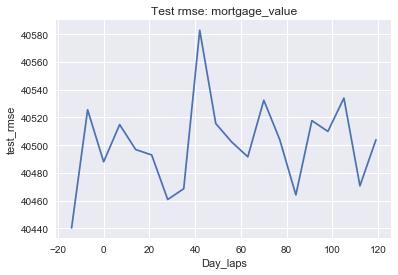

Sorry! Lowest test rmse of mortgage_value is 40440.2304687,which is not an improvement
(20, 3)


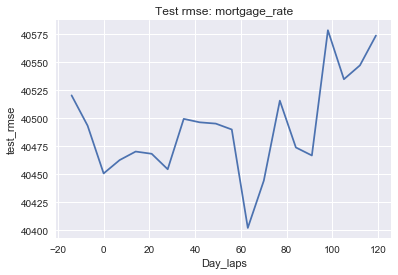

Congrat! Lowest test rmse of mortgage_rate is 40402.216146,which smaller than current best rmse 40402.5
Best time lapse is 63
(20, 3)


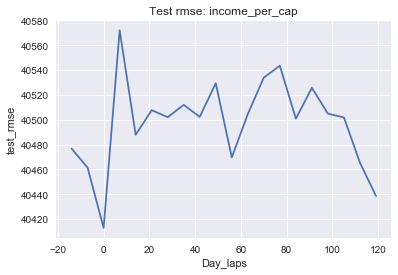

Sorry! Lowest test rmse of income_per_cap is 40412.8164063,which is not an improvement
(20, 3)


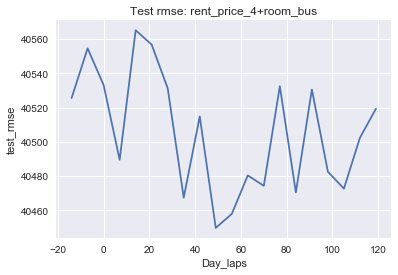

Sorry! Lowest test rmse of rent_price_4+room_bus is 40449.7148437,which is not an improvement
(20, 3)


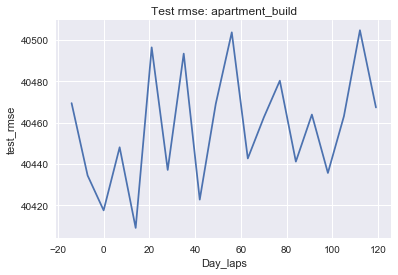

Sorry! Lowest test rmse of apartment_build is 40409.092448,which is not an improvement
(20, 3)


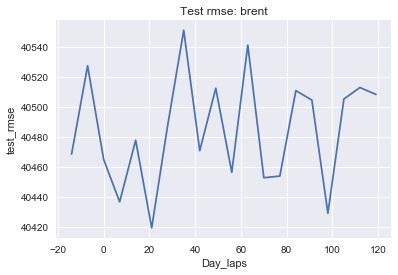

Sorry! Lowest test rmse of brent is 40419.3059893,which is not an improvement
(20, 3)


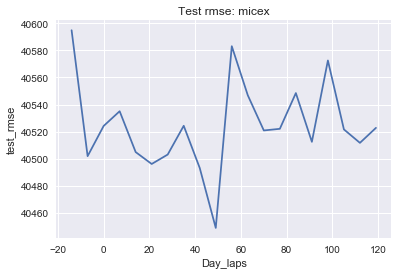

Sorry! Lowest test rmse of micex is 40448.8736983,which is not an improvement
(20, 3)


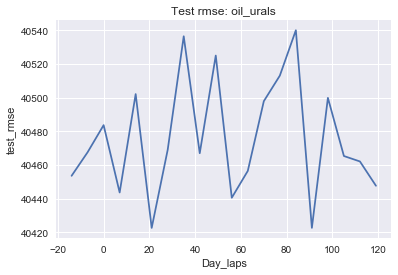

Sorry! Lowest test rmse of oil_urals is 40422.6263023,which is not an improvement
(20, 3)


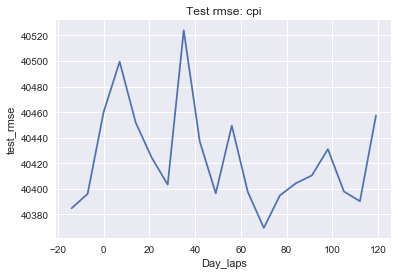

Congrat! Lowest test rmse of cpi is 40369.5052083,which smaller than current best rmse 40402.5
Best time lapse is 70
(20, 3)


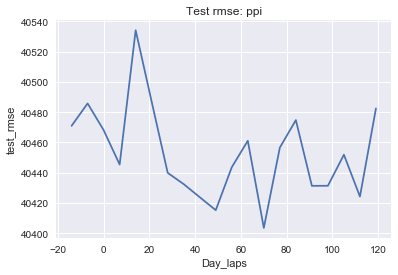

Sorry! Lowest test rmse of ppi is 40403.592448,which is not an improvement
(20, 3)


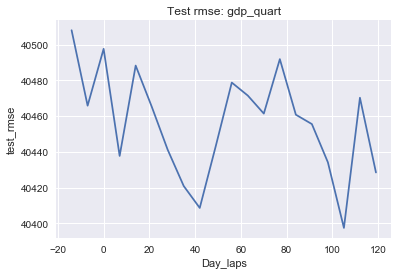

Congrat! Lowest test rmse of gdp_quart is 40397.4791667,which smaller than current best rmse 40402.5
Best time lapse is 105
(20, 3)


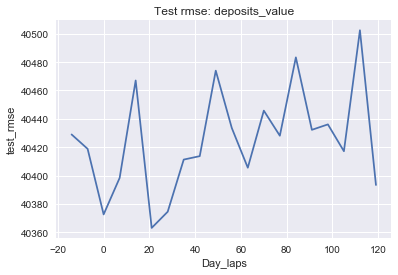

Congrat! Lowest test rmse of deposits_value is 40363.029948,which smaller than current best rmse 40402.5
Best time lapse is 21
(20, 3)


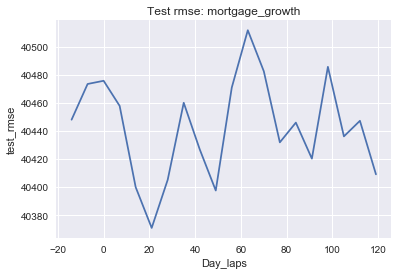

Congrat! Lowest test rmse of mortgage_growth is 40370.953125,which smaller than current best rmse 40402.5
Best time lapse is 21


In [207]:
macro_dict = {}
for col_name in macro_col:
    trend = pd.read_csv('./find_macro_time_laps/{}.csv'.format(col_name))
    print(trend.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(trend['n_days'],trend['test_rmse'])
    ax.set(xlabel = 'Day_laps',
           ylabel = 'test_rmse',
           title = 'Test rmse: {}'.format(col_name))
    plt.show()
    min_test_rmse = np.min(trend.test_rmse)
    best_n_day = int(trend.loc[trend.test_rmse==min_test_rmse,'n_days'])
    
    if min_test_rmse<40402.5:
        print('Congrat! Lowest test rmse of {} is {},which smaller than current best rmse 40402.5'.format(col_name,min_test_rmse))
        print('Best time lapse is {}'.format(best_n_day))
        macro_dict[col_name] = best_n_day
    else: 
        print('Sorry! Lowest test rmse of {} is {},which is not an improvement'.format(col_name,min_test_rmse))

In [208]:
macro_dict

{'cpi': 70,
 'deposits_rate': -7,
 'deposits_value': 21,
 'eurrub': 49,
 'gdp_quart': 105,
 'micex_rgbi_tr': -7,
 'mortgage_growth': 21,
 'mortgage_rate': 63}